In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle as astropy_ls
from scipy import optimize

import matplotlib 
matplotlib.rc('xtick', labelsize=36) 
matplotlib.rc('ytick', labelsize=36) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)


In [49]:
import pandas as pd

# File path to the TSV file
file_path = './holczer_catalog_wFlags.tsv'

# Define custom column header names
custom_column_headers = ['KOI', 'N', 't_lin', 'O-C', 'e_O-C', 'out']

# Load the TSV file into a DataFrame
holczer_catalog = pd.read_csv(file_path, delimiter='\t', skiprows=38, names=custom_column_headers)

# Filter the DataFrame to keep rows that do not contain '*'
mask = holczer_catalog['out'] != 0
holczer_catalog_noFlags = holczer_catalog.loc[~mask].copy()

print(holczer_catalog_noFlags)

# Calculate 'times' and 'times_err' columns
holczer_catalog_noFlags['times'] = holczer_catalog_noFlags['t_lin'] + (holczer_catalog_noFlags['O-C'] / (24. * 60.)) # convert to days
holczer_catalog_noFlags['times_err'] = holczer_catalog_noFlags['e_O-C'] / (24. * 60.) # convert to days


print(len(holczer_catalog))
print(len(holczer_catalog_noFlags))

holczer_catalog_noFlags




            KOI  N        t_lin     O-C  e_O-C  out
0          1.01  0    55.763337  -0.050   0.09    0
1          1.01  1    58.233950   0.077   0.09    0
2          1.01  2    60.704563  -0.037   0.09    0
4          1.01  5    68.116404  -0.003   0.09    0
5          1.01  6    70.587017   0.061   0.09    0
...         ... ..          ...     ...    ...  ...
295180  5970.01  2   430.952032  -5.000  20.00    0
295182  5970.01  4   734.097860  89.000  50.00    0
295183  5970.01  5   885.670773  -8.000  30.00    0
295184  5970.01  6  1037.243687   7.000  20.00    0
295185  5970.01  7  1188.816601   2.000  40.00    0

[221209 rows x 6 columns]
295187
221209


,KOI,N,t_lin,O-C,e_O-C,out,times,times_err
0,1.01,0,55.763337,-0.050,0.09,0,55.763302,0.000063
1,1.01,1,58.233950,0.077,0.09,0,58.234003,0.000063
2,1.01,2,60.704563,-0.037,0.09,0,60.704537,0.000063
4,1.01,5,68.116404,-0.003,0.09,0,68.116402,0.000063
5,1.01,6,70.587017,0.061,0.09,0,70.587059,0.000063
...,...,...,...,...,...,...,...,...
295180,5970.01,2,430.952032,-5.000,20.00,0,430.948560,0.013889
295182,5970.01,4,734.097860,89.000,50.00,0,734.159666,0.034722
295183,5970.01,5,885.670773,-8.000,30.00,0,885.665217,0.020833
295184,5970.01,6,1037.243687,7.000,20.00,0,1037.248548,0.013889


In [54]:
# Create a list of DataFrames, where each DataFrame represents a unique value in the 'KOI' column
holczer_catalog_by_koi = [group_df for _, group_df in holczer_catalog_noFlags.groupby('KOI')]

#length should be 2599
len(holczer_catalog_by_koi)



2599

To this end, we first extract the
quoted TTVs from H+16 and divide them by their quoted
uncertainties. We next measure the RMS of this list using a
median-based robust measure, specifically 1.4826 multiplied
by the median absolute deviation (MAD). We then remove
any transit times for which the quoted TTV normalised by
the quoted uncertainty exceeds 10 times this robust RMS
value. The idea here is to reject points which are dispersed an
order-of-magnitude more than the observed scatter. We also
remove any transit times for which the H+16 reported uncertainty is > 3 times greater than the median uncertainty of
that KOI, typically associated with partial transits of poorer
data quality.

In [6]:
holczer_catalog_by_koi_outlier_removed = []
for a_koi in holczer_catalog_by_koi:
    # Calculate O-C_norm by dividing O-C by e_O-C
    a_koi['O-C_norm'] = a_koi['O-C'] / a_koi['e_O-C']

    # Calculate the robust RMS (root mean square) using the median absolute deviation (MAD)
    robust_rms = 1.4826 * np.median(np.abs(a_koi['O-C'] - np.median(a_koi['O-C'])))

    # Create a new column called 'RMS' with the robust RMS value
    a_koi['RMS'] = robust_rms

    # Remove rows where O-C_norm exceeds 10 times the robust RMS value
    a_koi = a_koi[np.abs(a_koi['O-C_norm']) <= 10 * robust_rms]
    
    
    # Remove rows where e_O-C is > 3 times greater than the median of all e_O-C values
    median_e_O_C = np.median(a_koi['e_O-C'])
    a_koi = a_koi[a_koi['e_O-C'] <= 3 * median_e_O_C]
    
    holczer_catalog_by_koi_outlier_removed.append(a_koi)
    
holczer_catalog_by_koi_outlier_removed



/Users/daniel/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daniel/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[      KOI    N        t_lin    O-C  e_O-C  out        times  times_err  \
 0    1.01    0    55.763337 -0.050   0.09    0    55.763302   0.000063   
 1    1.01    1    58.233950  0.077   0.09    0    58.234003   0.000063   
 2    1.01    2    60.704563 -0.037   0.09    0    60.704537   0.000063   
 4    1.01    5    68.116404 -0.003   0.09    0    68.116402   0.000063   
 5    1.01    6    70.587017  0.061   0.09    0    70.587059   0.000063   
 ..    ...  ...          ...    ...    ...  ...          ...        ...   
 420  1.01  545  1402.247627  0.033   0.09    0  1402.247650   0.000063   
 424  1.01  585  1501.072162  0.013   0.08    0  1501.072171   0.000056   
 425  1.01  586  1503.542775 -0.069   0.09    0  1503.542727   0.000063   
 428  1.01  589  1510.954615 -0.050   0.09    0  1510.954580   0.000063   
 431  1.01  594  1523.307682 -0.043   0.08    0  1523.307652   0.000056   
 
      O-C_norm       RMS  
 0   -0.555556  0.089697  
 1    0.855556  0.089697  
 2   -0.411111  0

In [10]:
total_rows = sum(df.shape[0] for df in holczer_catalog_by_koi_outlier_removed)
total_rows

220754

In [11]:
len(holczer_catalog_by_koi_outlier_removed)

2599

In [12]:
def get_chisq(observed_data, predicted_data, uncertainties):
    """
    Calculate the chi-square statistic for model evaluation.

    Parameters:
        observed_data (numpy array): Array of observed data points.
        predicted_data (numpy array): Array of model-predicted data points.
        uncertainties (numpy array): Array of uncertainties/standard deviations of the observed data.

    Returns:
        float: The chi-square statistic.
    """
    if len(observed_data) != len(predicted_data) or len(observed_data) != len(uncertainties):
        raise ValueError("All input arrays must have the same length.")

    squared_residuals = ((observed_data - predicted_data) ** 2. / (uncertainties ** 2.) )
    chi_square = np.sum(squared_residuals)

    return chi_square


def get_log_likelihood(chi_square):
    """
    Calculate the log-likelihood from the chi-square value.

    Parameters:
        chi_square (float): The chi-square value of the model.
        num_data_points (int): Number of data points (sample size).

    Returns:
        float: The log-likelihood.
    """
    log_likelihood = -0.5 * chi_square
    return log_likelihood

def get_BIC(num_params, num_data_points, log_likelihood):
    """
    Calculate the Bayesian Information Criterion (BIC).

    Parameters:
        num_params (int): Number of parameters in the model.
        num_data_points (int): Number of data points (sample size).
        log_likelihood (float): Log-likelihood of the model.

    Returns:
        float: The BIC value.
    """
    BIC = num_params * np.log(num_data_points) - 2 * log_likelihood
    return BIC



def get_AIC(observed, predicted, uncertainties, num_parameters):
    """
    Calculate the Akaike Information Criterion (AIC) for a model with data uncertainties.

    Parameters:
        observed (array-like): The observed data.
        predicted (array-like): The model's predicted values.
        uncertainties (array-like): The uncertainties on the observed data.
        num_parameters (int): The number of parameters in the model.

    Returns:
        float: The AIC value.
    """
    # Calculate the number of data points
    n = len(observed)

    # Calculate the weighted sum of squared residuals (RSS)
    residuals = np.array(observed) - np.array(predicted)
    rss = np.sum((residuals / uncertainties)**2)

    # Calculate the AIC value
    aic = n * np.log(rss / n) + 2 * num_parameters

    return aic



def get_times_null_model(epochs, T0, P): 
    """
    Generates null model times based on linear ephemeris.

    Parameters:
    - epochs (np.array): Array of epochs.
    - T0 (float): Reference time of the first transit.
    - P (float): Orbital period.

    Returns:
    - np.array: Array of null model times.
    """
    return T0 + P*epochs


def solve_null_model(epochs, times, times_err):
    """
    Solves for T0 and P in a null model using linear regression.

    Parameters:
    - epochs (np.array): Array of epochs.
    - times (np.array): Array of observed transit times.
    - times_err (np.array): Array of errors associated with observed transit times.

    Returns:
    - Tuple: Tuple containing T0_fit (float) and P_fit (float), the fitted parameters.
    """
    
    # Constructing the design matrix A
    A = np.column_stack([
        np.ones_like(epochs),
        epochs
    ])

    # Constructing the weight matrix W using times_err
    W = np.diag(1.0 / times_err**2.)

    # Constructing the observed times vector y
    y = times

    # Calculating the parameters using np.linalg.solve
    parameters = np.linalg.solve(A.T @ W @ A, A.T @ W @ y)

    T0_fit, P_fit = parameters

    return T0_fit, P_fit



def get_times_n_waves(epochs, T0, P, P_LS_ttv, *fourier_params):
    """
    Calculate the time as a function of epochs with multiple waves.

    Parameters:
    - epochs: array-like, time values
    - T0: float, reference time
    - P: float, linear period
    - P_LS_ttv: float, period for the last wave
    - *fourier_params: variable number of Fourier parameters for each wave

    Returns:
    - times: array-like, calculated times
    """

    # Determine the number of waves
    n = (len(fourier_params) + 1) // 3

    # Calculate linear component
    linear = T0 + P * epochs

    # Initialize the total wave component
    waves = 0

    # Iterate through waves
    for ii in range(n - 1):
        alpha_i_ttv, beta_i_ttv, P_i_ttv = fourier_params[3 * ii: 3 * (ii + 1)]

        # Calculate wave for the current Fourier parameters
        wave_i = alpha_i_ttv * np.sin((2 * np.pi * epochs / P_i_ttv)) + beta_i_ttv * np.cos((2 * np.pi * epochs / P_i_ttv))

        # Add the current wave to the total
        waves += wave_i

    # Calculate the last wave separately
    alpha_LS_ttv, beta_LS_ttv = fourier_params[3 * (n - 1): 3 * n]
    wave_LS = alpha_LS_ttv * np.sin((2 * np.pi * epochs / P_LS_ttv)) + beta_LS_ttv * np.cos((2 * np.pi * epochs / P_LS_ttv))
    waves += wave_LS

    # Combine linear and wave components to get the final result
    times = linear + waves

    return times



def fit_multiple_frequencies(epochs, times, times_err, Pgrid, amplitude_cut=10., max_waves = 5):
    """
    Fit multiple frequencies to the given times and return optimized parameters.

    Parameters:
    - epochs: array-like, time values
    - times: array-like, observed times
    - times_err: array-like, errors on observed times
    - Pgrid: array-like, grid of periods to search for optimal fit
    - NOT USED HERE!! amplitude_cut: float, amplitude ratio threshold for wave detectability, default = 10.
    - max_waves: int, maximum number of waves, default = 2

    Returns:
    - optimized_params: array, optimized parameters for the best fit
    """

    # Solve null model and calculate null chisq
    null_model = solve_null_model(epochs, times, times_err)
    times_null_model = get_times_null_model(epochs, *null_model)
    null_chisq = get_chisq(times, times_null_model, times_err)

    n_waves = 1
    amplitude_detectable = True
    
    optimized_params_dict = {}
    while n_waves <= max_waves:
    #while amplitude_detectable and n_waves <= max_waves:
        #print('n waves: ', n_waves)

        # Initial guesses for the parameters
        if n_waves == 1:
            initial_guess = [0, 0, *([0, 0] * n_waves)]
        else:
            linear_params = list(optimized_params[0:2])
            fourier_params = list(optimized_params[2:len(optimized_params)]) + [best_P_ttv] + [0, 0]

            initial_guess = [*linear_params, *fourier_params]
            ntest = (len(fourier_params) + 1) // 3

        delta_chisq_grid = []
        ttv_chisq_grid = []
        
        for P_LS_ttv in Pgrid:
            try:
                # Create a lambda function with fixed P_LS_ttv
                fit_function = lambda epochs, T0, P, *fourier_params: get_times_n_waves(epochs, T0, P, P_LS_ttv,
                                                                                        *fourier_params)

                # Use curve_fit
                optimized_params, _ = optimize.curve_fit(fit_function, epochs, times, sigma=times_err, p0=initial_guess)

                # Extract optimized parameters
                T0_optimized, P_optimized, *fourier_params_optimized = optimized_params

                # Evaluate the function with the best-fit values
                best_fit_times = get_times_n_waves(epochs, T0_optimized, P_optimized, P_LS_ttv,
                                                   *fourier_params_optimized)

                # Calculate delta_chisq and ttv_chisq
                a_chisq = get_chisq(times, best_fit_times, times_err)
                #delta_chisq = max(0., null_chisq - a_chisq)
                delta_chisq = null_chisq - a_chisq
                delta_chisq_grid.append(delta_chisq)
                ttv_chisq_grid.append(a_chisq)

            except RuntimeError:
                # Exclude the problematic P_LS_ttv from the grid
                Pgrid = Pgrid[Pgrid != P_LS_ttv]
                continue
        

        # Find the period with maximum delta_chisq
        max_delta_chisq = -np.inf
        min_ttv_chisq = 0
        best_P_ttv = None
        

        for ii in range(len(delta_chisq_grid)):
            delta_chisq = delta_chisq_grid[ii]
            ttv_chisq = ttv_chisq_grid[ii]
            period = Pgrid[ii]

            if delta_chisq > max_delta_chisq:
                max_delta_chisq = delta_chisq
                min_ttv_chisq = ttv_chisq
                best_P_ttv = period
                
        

        
        
        
        # Recalculate the model with the best period
        P_LS_ttv = best_P_ttv

        # Create a lambda function with fixed P_LS_ttv
        fit_function = lambda epochs, T0, P, *fourier_params: get_times_n_waves(epochs, T0, P, P_LS_ttv,
                                                                                *fourier_params)

        # Use curve_fit
        optimized_params, _ = optimize.curve_fit(fit_function, epochs, times, sigma=times_err, p0=initial_guess)

        # Extract optimized parameters
        T0_optimized, P_optimized, *fourier_params_optimized = optimized_params

        
        #best_fit_times_epochs = get_times_n_waves(epochs, T0_optimized, P_optimized, P_LS_ttv,
        #                                          *fourier_params_optimized)
        
        #add optimized_params for nth wave to dict
        optimized_params_dict[n_waves] = list(optimized_params) + [best_P_ttv] 
        
        #if not evaluated by amplitude cut, skip this!
        '''
        # Get the amplitude of the nth wave
        amplitude_comps = fourier_params_optimized[-2:len(fourier_params_optimized)]
        amplitude = np.sqrt(amplitude_comps[0] ** 2. + amplitude_comps[1] ** 2.)
        print('amplitudes')
        print('----------')
        print(amplitude)

        # If it's not the first wave, compare amplitudes
        if n_waves != 1:
            amplitude_comps_1st = fourier_params_optimized[0:2]
            amplitude_1st = np.sqrt(amplitude_comps_1st[0] ** 2. + amplitude_comps_1st[1] ** 2.)

            print(amplitude_1st)

            print('amp ratio = ', str(amplitude_1st / amplitude))
            if amplitude_1st / amplitude > amplitude_cut:
                amplitude_detectable = False
        '''

        n_waves += 1
        #print('')
        #print('')

    # Return optimized parameters, excluding the last 2 parameters as the nth wave didn't survive
    #return optimized_params[0:-2]
    
    # Return optimized parameters, add in the best Pttv of last wave
    #return list(optimized_params) + [best_P_ttv] 
    return optimized_params_dict


In [13]:
np.random.seed(63)
pttvs = np.concatenate([np.round(np.random.uniform(2, 50, 1),2), np.round(np.random.uniform(2, 5, 2), 2)])

pttvs

array([28.59,  3.19,  2.14])

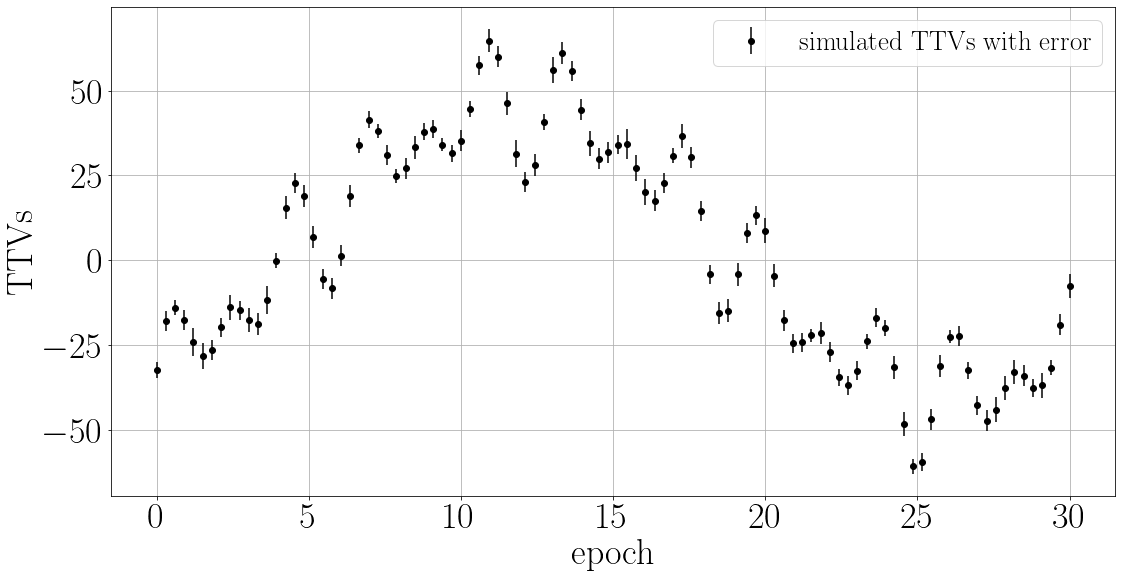

In [14]:
# Step 1: Generate epochs
num_epochs = 100
epochs = np.linspace(0, 30, num_epochs)

# Step 2: Setup Pgrid
Pmin = 2
Pmax = 2*(np.max(epochs)-np.min(epochs))
fmin = 1/Pmax
fmax = 1/Pmin


fgrid = np.linspace(fmin, fmax, 10*len(epochs))
Pgrid = np.sort(1/fgrid)
    

    
np.random.seed(63)
pttvs = np.concatenate([np.round(np.random.uniform(2, 50, 1),2), np.round(np.random.uniform(2, 5, 2), 2)])

# Step 3: Generate Fourier parameters 
alpha_ttv_true = 23
beta_ttv_true = -36
P_LS_ttv_true = pttvs[0]
P_LS_ttv = P_LS_ttv_true

alpha_ttv_2_true = 9.7
beta_ttv_2_true = -4.5
P_ttv_2_true = pttvs[1]

alpha_ttv_3_true = 10.5
beta_ttv_3_true = 5.7
P_ttv_3_true = pttvs[2]
fourier_params_true = [alpha_ttv_true, beta_ttv_true, P_LS_ttv_true,
                       alpha_ttv_2_true, beta_ttv_2_true, P_ttv_2_true,
                       alpha_ttv_3_true, beta_ttv_3_true, P_ttv_3_true]
fourier_params_input = [alpha_ttv_3_true, beta_ttv_3_true, P_ttv_3_true,
                        alpha_ttv_2_true, beta_ttv_2_true, P_ttv_2_true,
                        alpha_ttv_true, beta_ttv_true]

P_ttvs_true = [P_LS_ttv_true, P_ttv_2_true, P_ttv_3_true]

# Step 4: Calculate times using the get_times_n_waves function
T0_true = 25
P_true = 18
linear_params_true = [T0_true, P_true]

linear_ephemeris = T0_true + P_true * epochs
times = get_times_n_waves(epochs, T0_true, P_true, P_LS_ttv, *fourier_params_input)

# Step 6: Add Gaussian noise to simulate measurement errors
mean_error = 3
std_deviation = .5  # Adjust the standard deviation to control the level of noise
times_err = np.random.normal(mean_error, std_deviation, num_epochs)
times += times_err

# Step 5: Subtract the linear ephemeris to obtain TTVs
ttvs = times - linear_ephemeris


# Plot the results
plt.figure(figsize=(18, 9))
plt.errorbar(epochs, ttvs, yerr=times_err, fmt='ko', label='simulated TTVs with error')
plt.xlabel('epoch', fontsize=36)
plt.ylabel('TTVs', fontsize=36)
plt.legend(fontsize=27)
plt.grid(True)
plt.show()




(54.358465842642566, 2.204735408158086)
[   2.            2.00037765    2.00075544 ... 1064.35231908 1183.2294256
 1332.        ]


/Users/daniel/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[54.35846570769314, 2.204735408834714, 2.1797915517589187e-05, -2.5738545349086636e-05, 2.0091030579087947]


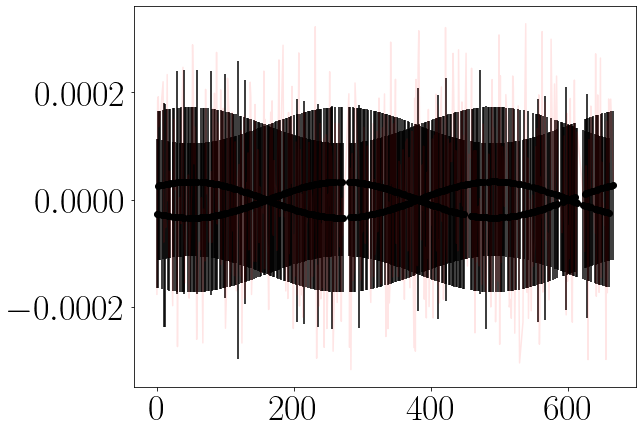

511.37619903712937
525.8232254843347
14.447026447205303




NameError: name 'kois_LS_fit' is not defined

In [15]:
koi = holczer_catalog_by_koi_outlier_removed[1]['KOI'].values[0]
epochs = holczer_catalog_by_koi_outlier_removed[1]['N'].values
times = holczer_catalog_by_koi_outlier_removed[1]['times'].values
times_err = holczer_catalog_by_koi_outlier_removed[1]['times_err'].values

null_model  = solve_null_model(epochs, times, times_err)

print(null_model)


times_null_model = get_times_null_model(epochs, *null_model)
null_chisq = get_chisq(times, times_null_model, times_err)


#determine minimum temporal spacing
min_spacing = float('inf')  # Initialize minimum spacing to positive infinity

for i in range(1, len(epochs)):
    spacing = epochs[i] - epochs[i-1]
    if spacing < min_spacing:
        min_spacing = spacing


#define grid for LS
Pmin = 2.
Pmax = 2.*(np.max(epochs)-np.min(epochs))
fmin = 1/Pmax
fmax = 1/Pmin



fgrid = np.linspace(fmin, fmax, 10*len(times))
Pgrid = np.sort(1/fgrid)

print(Pgrid)



optimized_params_dict = fit_multiple_frequencies(epochs, times, times_err, Pgrid, max_waves=1)
optimized_params = optimized_params_dict[1]


# Extracting the optimized parameters from the result
t0, p_lin, alpha_ttv, beta_ttv, p_ttv = optimized_params

print([t0, p_lin, alpha_ttv, beta_ttv, p_ttv])

# Now you can use the optimized parameters to evaluate the function with the best-fit values:
best_fit_times_epochs = get_times_n_waves(epochs, 
                                          t0, 
                                          p_lin,
                                          p_ttv,
                                          alpha_ttv, 
                                          beta_ttv)

chisq = get_chisq(times, best_fit_times_epochs, times_err)
delta_chisq = null_chisq - chisq

plt.figure(figsize=[9,7])
plt.errorbar(epochs, best_fit_times_epochs-times_null_model, yerr=times_err, ls='', marker='o', color='k')
plt.plot(epochs, times-times_null_model, 'r', alpha=0.1)
plt.show()
print(chisq)
print(null_chisq)
print(delta_chisq)
print('')
print('')


#ttvs_max_model = get_times_ttv_model(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

#ttvs_input = times - get_times_null_model(epochs, *max_model[0:2])


#plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
#plt.plot(epochs_plot, ttvs_max_model, 'r')

#plt.show()


BIC_ttv = get_BIC(4, len(times), 
                  get_log_likelihood(chisq))
BIC_ttv_linear = get_BIC(2, len(times), 
                         get_log_likelihood(null_chisq))


delta_BIC = BIC_ttv_linear-BIC_ttv


amplitude_ttv = np.sqrt(alpha_ttv**2. + beta_ttv**2.)


kois_LS_fit.append([koi, p_ttv, amplitude_ttv*24.*60., delta_BIC, p_lin, p_lin*p_ttv])

 

In [ ]:
koi = holczer_catalog_by_koi_outlier_removed[1]['KOI'].values[0]
epochs = holczer_catalog_by_koi_outlier_removed[1]['N'].values
times = holczer_catalog_by_koi_outlier_removed[1]['times'].values
times_err = holczer_catalog_by_koi_outlier_removed[1]['times_err'].values


optimized_params_dict = fit_multiple_frequencies(epochs, times, times_err, Pgrid, max_waves=1)
print(optimized_params_dict[1])

for ii in range(1, len(optimized_params_dict)+1):
    optimized_params = optimized_params_dict[ii]
    
    
    # Extracting the optimized parameters from the result
    T0_optimized, P_optimized, *fourier_params_optimized, P_LS_ttv = optimized_params


    # define an tightly spaced epoch for plotting
    epochs_plot = np.arange(np.min(epochs), np.max(epochs), 0.01)

    # Now you can use the optimized parameters to evaluate the function with the best-fit values:
    best_fit_times_plot = get_times_n_waves(epochs_plot, 
                                            T0_optimized, 
                                            P_optimized,
                                            P_LS_ttv,
                                            *fourier_params_optimized)

    # Now you can use the optimized parameters to evaluate the function with the best-fit values:
    best_fit_times_epochs = get_times_n_waves(epochs, 
                                              T0_optimized, 
                                              P_optimized,
                                              P_LS_ttv,
                                              *fourier_params_optimized)


    
    
    print(T0_optimized, P_optimized)
    ttvs_best_model = best_fit_times_plot - get_times_null_model(epochs_plot, T0_optimized, P_optimized)

    ttvs_input = times - get_times_null_model(epochs, T0_optimized, P_optimized)



    plt.figure(figsize=[18,9])
    plt.errorbar(epochs, ttvs_input*24*60, yerr=times_err, ls='', marker='o', color='k', label='simulated TTVs with error', zorder=-1000)
    plt.plot(epochs_plot, ttvs_best_model, 'r', label=str(ii) + ' sine wave model')
    plt.xlabel('epoch', fontsize=36)
    plt.ylabel('TTVs', fontsize=36)
    plt.legend(fontsize=27)
    plt.grid(True)

    plt.show()



For the period grid, we define the shortest period using the Nyquist rate (Nyquist 1928), which is given by the
twice the minimum temporal spacing between any two transit times (almost always 2 cycles). The longest period is
given by twice the temporal baseline of the transit times. In
principle, the number of periods/frequencies scanned should
be equal to the number of transit times (VanderPlas 2018),
but in practice we overscan by a factor of ten to create a
smooth, dense periodogram.


Here we run a faster verion with the number of periods/frequencies scanned 
 equal to the number of transit times (VanderPlas 2018)*10

In [33]:
from tqdm import tqdm

kois_LS_fit_after_2313 = []
for koi_index in tqdm(range(2314, len(holczer_catalog_by_koi_outlier_removed))):    
        
    koi = holczer_catalog_by_koi_outlier_removed[koi_index]['KOI'].values[0]
    epochs = holczer_catalog_by_koi_outlier_removed[koi_index]['N'].values
    times = holczer_catalog_by_koi_outlier_removed[koi_index]['times'].values
    times_err = holczer_catalog_by_koi_outlier_removed[koi_index]['times_err'].values
    
    #if not at least 4 data points...can't run...
    if len(times) < 4:
        kois_LS_fit_after_2313.append([koi, None, None, None])
        continue
    
    null_model  = solve_null_model(epochs, times, times_err)
    times_null_model = get_times_null_model(epochs, *null_model)
    null_chisq = get_chisq(times, times_null_model, times_err)
    
    
    #determine minimum temporal spacing
    min_spacing = float('inf')  # Initialize minimum spacing to positive infinity
    
    for i in range(1, len(epochs)):
        spacing = epochs[i] - epochs[i-1]
        if spacing < min_spacing:
            min_spacing = spacing
            
    
    #define grid for LS
    Pmin = 2.*min_spacing
    Pmax = 2.*(np.max(epochs)-np.min(epochs))
    fmin = 1/Pmax
    fmax = 1/Pmin
    

    fgrid = np.linspace(fmin, fmax, 10*len(times))
    Pgrid = np.sort(1/fgrid)
    

    

    optimized_params_dict = fit_multiple_frequencies(epochs, times, times_err, Pgrid, max_waves=1)
    optimized_params = optimized_params_dict[1]


    # Extracting the optimized parameters from the result
    t0, p_lin, alpha_ttv, beta_ttv, p_ttv = optimized_params
    

    # Now you can use the optimized parameters to evaluate the function with the best-fit values:
    best_fit_times_epochs = get_times_n_waves(epochs, 
                                              t0, 
                                              p_lin,
                                              p_ttv,
                                              alpha_ttv, 
                                              beta_ttv)

    chisq = get_chisq(times, best_fit_times_epochs, times_err)
    delta_chisq = null_chisq - chisq
    
    
    #plt.errorbar(epochs, best_fit_times_epochs-times_null_model, yerr=times_err, ls='', marker='o', color='k')
    #plt.plot(epochs, times-times_null_model, 'r', alpha=0.1)
    #plt.show()



    #ttvs_max_model = get_times_ttv_model(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

    #ttvs_input = times - get_times_null_model(epochs, *max_model[0:2])


    #plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
    #plt.plot(epochs_plot, ttvs_max_model, 'r')

    #plt.show()


    BIC_ttv = get_BIC(4, len(times), 
                      get_log_likelihood(chisq))
    BIC_ttv_linear = get_BIC(2, len(times), 
                             get_log_likelihood(null_chisq))
    

    delta_BIC = BIC_ttv_linear-BIC_ttv
    

    amplitude_ttv = np.sqrt(alpha_ttv**2. + beta_ttv**2.)
    

    kois_LS_fit_after_2313.append([koi, p_ttv, amplitude_ttv*24.*60., delta_BIC, p_lin, p_lin*p_ttv])
    
 

  0%|                                                   | 0/285 [00:00<?, ?it/s]/Users/daniel/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|█████████████████████████████████████████| 285/285 [01:56<00:00,  2.45it/s]


In [55]:
holczer_catalog_by_koi_outlier_removed[2313]

,KOI,N,t_lin,O-C,e_O-C,out,times,times_err,O-C_norm,RMS


In [40]:
kois_LS_fit_combined = kois_LS_fit_through_2313+kois_LS_fit_after_2313

In [41]:
len(kois_LS_fit_combined)

2598

In [43]:
# Create the pandas DataFrame
columns = ['KOI', 'P_ttv [cycles]', 'amplitude_ttv [min]', 'delta_BIC', 'P_lin', 'P_ttv [days]']
kois_LS_fit_df = pd.DataFrame(kois_LS_fit_combined, columns=columns)

# Display the DataFrame
kois_LS_fit_df

,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin,P_ttv [days]
0,1.01,2.853920,0.014495,-8.336251,2.470613,7.050934
1,2.01,2.009103,0.048569,1.905050,2.204735,4.429541
2,3.01,3.139865,0.102346,13.245529,4.887803,15.347040
3,5.01,10.890161,0.547617,-0.504880,4.780329,52.058552
4,7.01,12.710475,1.033167,2.070013,3.213667,40.847238
...,...,...,...,...,...,...
2593,5958.01,NaN,NaN,NaN,NaN,NaN
2594,5959.01,2.554113,71.884221,16.715621,251.479044,642.305784
2595,5968.01,2.819939,49.689695,9.243937,97.943227,276.193921
2596,5969.01,12.000000,137.573904,1.755848,163.847154,1966.165851


In [44]:
# Specify the file path where you want to save the CSV file
file_path = 'holczer_LS_fit_Aug2024.csv'

# Save the DataFrame as a CSV file
kois_LS_fit_df.to_csv(file_path, index=False)

In [45]:
holczer = kois_LS_fit_df[kois_LS_fit_df['delta_BIC'] > 10]
print(len(holczer))

holczer_koi_planets = []
holczer_ttv_amplitudes = []
holczer_ttv_BICs = []
for koi in holczer.values:
    if koi[0] not in holczer_koi_planets:
        holczer_koi_planets.append(koi[0])
        holczer_ttv_amplitudes.append(koi[2])
        holczer_ttv_BICs.append(koi[3])

1197


In [83]:
holczer

,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin,P_ttv [days]
2,3.01,3.138830,1.056643e-01,15.435857,4.887803,15.341984
6,12.01,69.921847,1.153954e+00,260.519694,17.855219,1248.469909
8,17.01,3.368362,1.112757e-01,10.630631,3.234699,10.895637
13,41.02,2.267717,3.266155e+01,241.972726,6.887125,15.618050
14,41.03,28.048104,5.875323e+01,101.518024,35.333128,991.027235
...,...,...,...,...,...,...
2590,5945.01,2.000000,5.559508e+15,75.115233,40.719409,81.438817
2592,5952.01,16.000000,3.572241e+02,38.596757,164.439615,2631.033835
2593,5955.01,2.751445,3.713080e+01,25.975905,96.329085,265.044188
2595,5959.01,2.554113,7.188461e+01,16.715621,251.479044,642.305784


In [84]:
holczer_planets = []
for ii in range(0, len(holczer_koi_planets)):
    holczer_planets.append([holczer_koi_planets[ii], holczer_ttv_amplitudes[ii], holczer_ttv_BICs[ii]])


In [85]:
exoplanet_archive_kois = pd.read_csv('kois_exoplanet_archive.csv')
exoplanet_archive_kois

,kepoi_name,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_count
0,752.01,CONFIRMED,9.488036,2.775000e-05,-2.775000e-05,2.26,0.26,-0.15,2
1,752.02,CONFIRMED,54.418383,2.479000e-04,-2.479000e-04,2.83,0.32,-0.19,2
2,753.01,CANDIDATE,19.899140,1.494000e-05,-1.494000e-05,14.60,3.92,-1.31,1
3,754.01,FALSE POSITIVE,1.736952,2.630000e-07,-2.630000e-07,33.46,8.50,-2.83,1
4,755.01,CONFIRMED,2.525592,3.761000e-06,-3.761000e-06,2.75,0.88,-0.35,1
...,...,...,...,...,...,...,...,...,...
9559,7985.01,FALSE POSITIVE,0.527699,1.160000e-07,-1.160000e-07,29.35,7.70,-2.57,1
9560,7986.01,CANDIDATE,1.739849,1.780000e-05,-1.780000e-05,0.72,0.24,-0.08,1
9561,7987.01,FALSE POSITIVE,0.681402,2.434000e-06,-2.434000e-06,1.07,0.36,-0.11,1
9562,7988.01,CANDIDATE,333.486169,4.235000e-03,-4.235000e-03,19.30,0.55,-4.68,1


In [86]:
ttv_single_planets = []
ttv_multi_planets = []
ttv_planets = []

for ii in range(0, len(holczer_planets)):
    koi = holczer_planets[ii][0]
    amplitude = holczer_planets[ii][1]
    BICs = holczer_planets[ii][2]
    
    period = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name'] == koi]['koi_period'].values
    disposition = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name'] == koi]['koi_disposition'].values
    nplanets = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name'] == koi]['koi_count'].values
    
    period = float(period)
    
    if disposition != 'FALSE POSITIVE':
        ttv_planets.append([koi, period, amplitude])
        
        if nplanets > 1:
            ttv_multi_planets.append([period, amplitude, BICs])
        elif nplanets == 1:
            ttv_single_planets.append([period, amplitude, BICs])
            
            
            
            
            
print(len(ttv_planets))
print(len(ttv_single_planets + ttv_multi_planets))


ttv_multi_planets = np.array(ttv_multi_planets).T
ttv_multi_planet_periods = ttv_multi_planets[0]
ttv_multi_planet_amplitudes = ttv_multi_planets[1]
ttv_multi_planet_BICs = ttv_multi_planets[2]


ttv_single_planets = np.array(ttv_single_planets).T
ttv_single_planet_periods = ttv_single_planets[0]
ttv_single_planet_amplitudes = ttv_single_planets[1]
ttv_single_planet_BICs = ttv_single_planets[2]

1775
1775


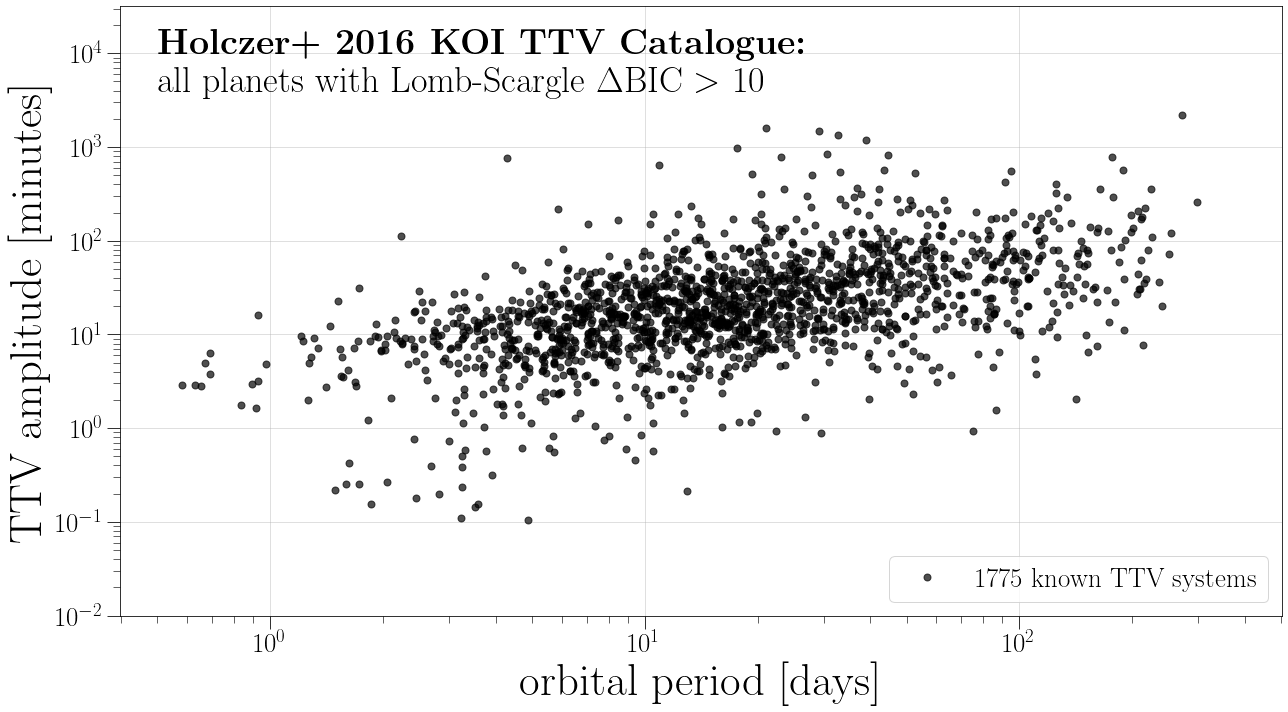

In [117]:
plt.figure(figsize=[18,10])

'''
plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')

plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')

'''
plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')

plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2)


plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_all.pdf')

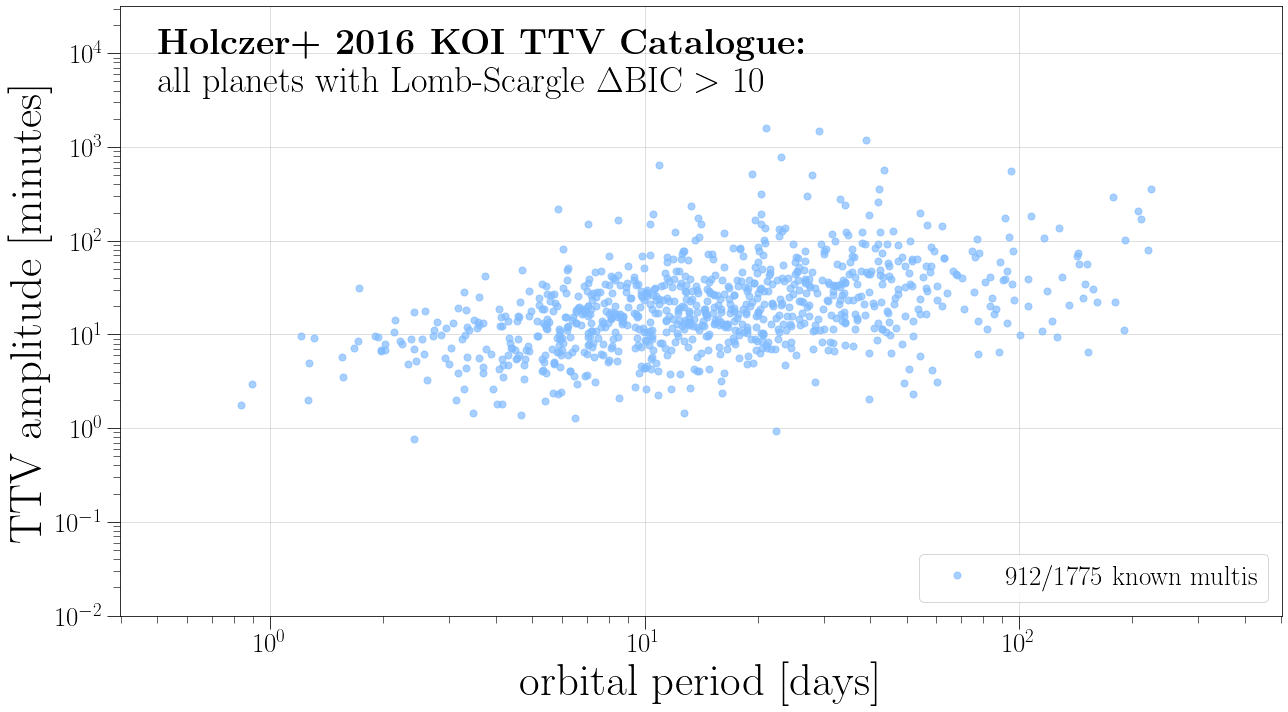

In [118]:
plt.figure(figsize=[18,10])


plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')
'''
plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')


plt.plot(np.log10(np.array(ttv_planets).T[0]), np.log10(np.array(ttv_planets).T[1]), 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')
'''

plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_multis.pdf')

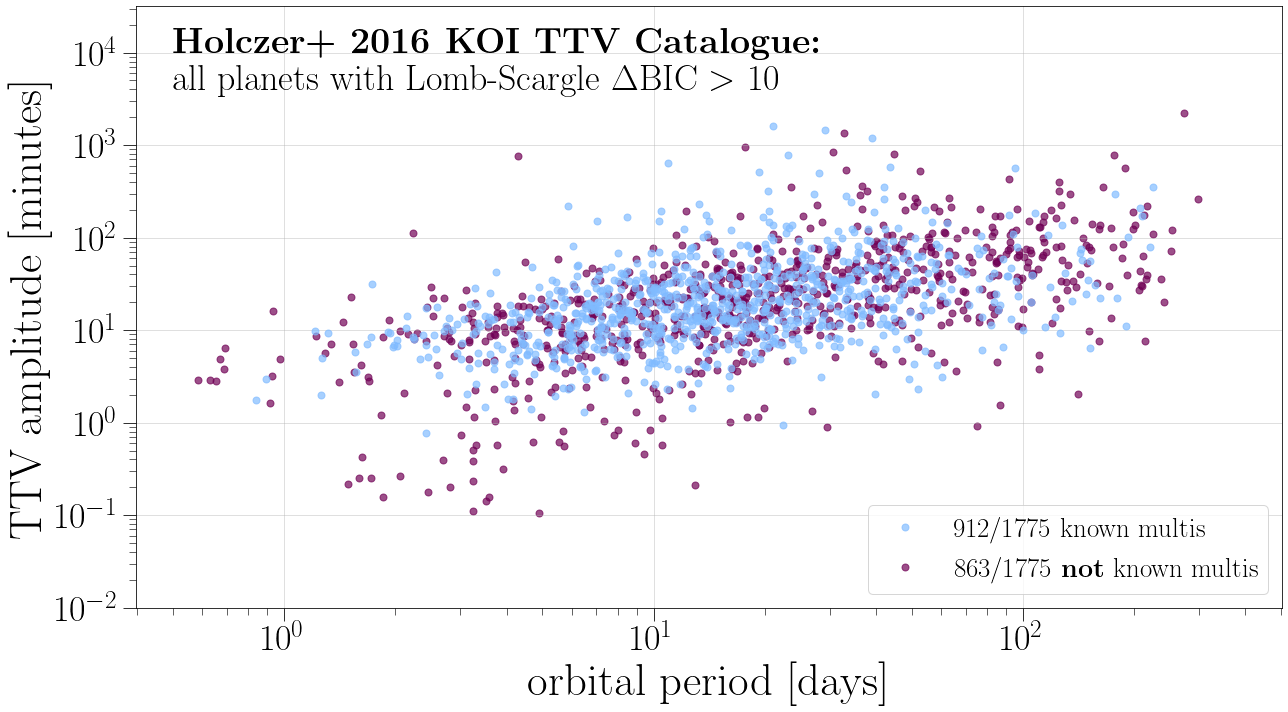

In [119]:

plt.figure(figsize=[18,10])


plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')

plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')

'''
plt.plot(np.log10(np.array(ttv_planets).T[0]), np.log10(np.array(ttv_planets).T[1]), 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')
'''

plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)

plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_singles_vs_multis.pdf')

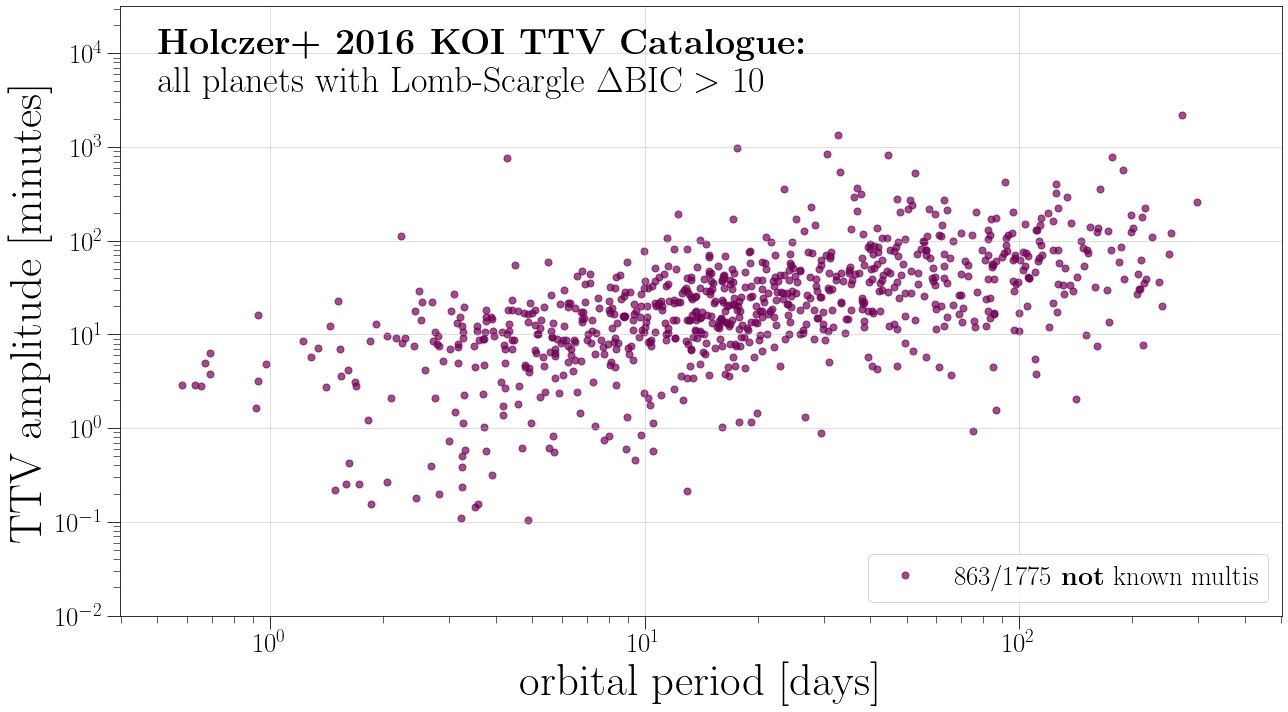

In [120]:
plt.figure(figsize=[18,10])

'''
plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')
'''

plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')

'''
plt.plot(np.log10(np.array(ttv_planets).T[0]), np.log10(np.array(ttv_planets).T[1]), 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')
'''

plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_singles.pdf')